PRÉ PROCESSAMENTO

In [1]:
#Limpa texto bruto

import re

# Regex pré-compiladas
URL_MENCAO_REGEX = re.compile(r"http\S+|www\S+|https\S+|@\w+|#")
EMOJI_SYMBOL_REGEX = re.compile(r"[^\w\s\-áéíóúâêôãõç]", flags=re.UNICODE)

ABREVIACOES = {
    "q": "que", "pq": "porque", "vc": "você", "vcs": "vocês", "tb": "também",
    "blz": "beleza", "hj": "hoje", "amanha": "amanhã", "mt": "muito", "td": "tudo",
    "obg": "obrigado", "vlw": "valeu", "msg": "mensagem", "n": "não", "s": "sim",
    "tbm": "também", "p": "para", "nao": "não"
}
ABREVIACOES_REGEX = re.compile(r'\b(' + '|'.join(map(re.escape, ABREVIACOES.keys())) + r')\b', flags=re.IGNORECASE)

def substituir_abreviacoes(match):
    palavra = match.group(0).lower()
    return ABREVIACOES.get(palavra, palavra)

def limpar_texto_bruto(texto: str) -> str:
    texto = URL_MENCAO_REGEX.sub(" ", texto)
    texto = ABREVIACOES_REGEX.sub(substituir_abreviacoes, texto)
    texto = EMOJI_SYMBOL_REGEX.sub(" ", texto)
    return texto

In [2]:
#Configuração do spaCy e Matcher

import spacy
import nltk
from spacy.matcher import Matcher

nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))
matcher = Matcher(nlp.vocab)

# Adiciona padrões
matcher.add("NUM_UNIDADE", [[
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]])
matcher.add("SUBSTANTIVOS", [[{"POS": "NOUN"}]])
matcher.add("PROPRIOS", [[{"POS": "PROPN"}]])
matcher.add("ADJETIVOS", [[{"POS": "ADJ"}]])

In [5]:
from spacy.util import filter_spans

def capitalizar_palavras(texto):
    return ' '.join(p.capitalize() for p in texto.split())

def pre_processar_doc(doc):
    from collections import defaultdict

    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        if i in ent_by_start:
            ent = ent_by_start[i]
            tokens.append(capitalizar_palavras(ent.text.lower()))
            i = ent.end
        elif i in spans_dict:
            span = spans_dict[i]
            span_text = span.text.lower()
            if len(span) == 1:
                token = span[0]
                if token.pos_ == "VERB":
                    tokens.append(token.lemma_)
                elif token.is_alpha and token.text.lower() not in stopwords and len(token.text) >= 3:
                    tokens.append(token.text.lower())
            elif len(span_text) >= 3:
                tokens.append(span_text)
            i = span.end
        else:
            i += 1

    return tokens

PROCESSAR LOTES DE TEXTOS

In [6]:
def processar_lote_textos(lista_de_textos, batch_size=1000, n_process=1):
    docs = nlp.pipe([limpar_texto_bruto(txt) for txt in lista_de_textos],
                    batch_size=batch_size,
                    n_process=n_process)
    return [pre_processar_doc(doc) for doc in docs]

CLUSTERIZAÇÃO

In [19]:
import networkx as nx

def extrair_clusters_com_ramos(graphml_path):
    G = nx.read_graphml(graphml_path)
    if "0" in G:
        G.remove_node("0")

    def nome(n):
        return G.nodes[n].get("value", n)

    componentes = []
    visitados = set()

    for raiz in G.nodes:
        if raiz in visitados or G.out_degree(raiz) == 0:
            continue

        descendentes = nx.descendants(G, raiz)
        cluster_nos = {raiz} | descendentes
        if len(cluster_nos) <= 2:
            continue
        visitados |= cluster_nos

        folhas = [n for n in cluster_nos if G.out_degree(n) == 0]
        ramos = []
        for folha in folhas:
            for caminho in nx.all_simple_paths(G, raiz, folha):
                ramos.append([nome(n) for n in caminho])

        componentes.append({
            "raiz": nome(raiz),
            "ramos": ramos,
            "n_nos": len(cluster_nos),
            "ids": cluster_nos
        })

    #Exibir
    for idx, c in enumerate(componentes, 1):
        print(f"Cluster {idx} — Raiz: {c['raiz']} — {c['n_nos']} nós")
        print("Ramos: ")
        #print(c["ramos"])
        for ramo in c["ramos"]:
            print(" → ".join(ramo))
        print("-" * 80)

    return componentes


TWEETS MAIS RELEVANTES

In [17]:
def encontrar_tweets_relacionados(componentes, textos_tokenizados, textos_originais):
    resultados = []

    for idx, c in enumerate(componentes, 1):
        ramos_sets = [set(r) for r in c["ramos"]]
        tweets_relevantes = []

        for i, tokens in enumerate(textos_tokenizados):
            tokens_set = set(tokens)
            if any(ramo.issubset(tokens_set) for ramo in ramos_sets):
                tweets_relevantes.append({
                    "tweet": textos_originais[i],
                    "index": i
                })

        resultados.append({
            "cluster_idx": idx,
            "raiz": c["raiz"],
            "n_nos": c["n_nos"],
            "n_tweets": len(tweets_relevantes),
            "tweets": tweets_relevantes
        })

        print(f"Cluster {idx} ({c['raiz']}) — {len(tweets_relevantes)} tweets relacionados")

    return resultados


MAIN

In [24]:
import pandas as pd
from trieofrules import trieofrules

# 1. Carrega o CSV
print("Carregando dataset...")
df = pd.read_csv("datasets/vacinal_2025_06_03.csv")
lista_de_textos = df["description"].astype(str).tolist()

# 2. Pré-processamento
print("Pré-processando textos com spaCy...")
resultado = processar_lote_textos(lista_de_textos, batch_size=1000, n_process=1)


Carregando dataset...
Pré-processando textos com spaCy...


Gerando árvore de regras (TOR)...
Salvando .graphml...


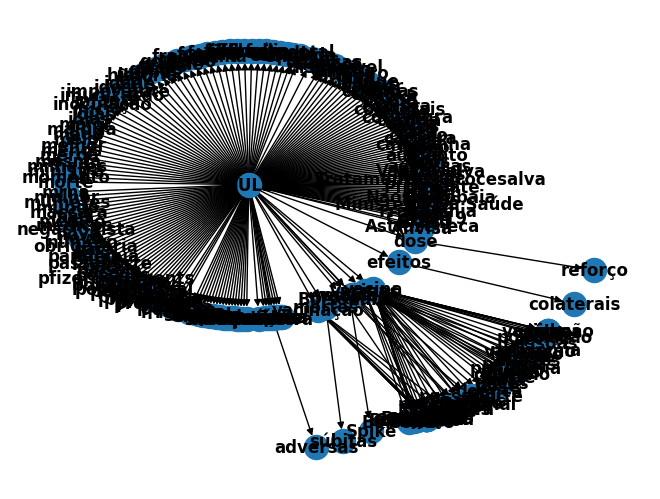

In [28]:
# 3. Gera o TOR (Trie of Rules) a partir dos dados
print("Gerando árvore de regras (TOR)...")
TOR = trieofrules(data=resultado, alg='Apriori', min_support=0.005)
TOR.draw()

# 4. Salva a visualização e estrutura como .graphml
print("Salvando .graphml...")
TOR.save_graph(filename="outputs/database_inteiro.graphml")

In [30]:
# 5. Extrai clusters com ramos hierárquicos
print("Extraindo clusters e ramos do grafo...")
componentes = extrair_clusters_com_ramos("outputs/database_inteiro.graphml")

Extraindo clusters e ramos do grafo...
Cluster 1 — Raiz: proteína — 3 nós
Ramos: 
proteína → spike
proteína → Spike
--------------------------------------------------------------------------------
Cluster 2 — Raiz: vacina — 36 nós
Ramos: 
vacina → cartão
vacina → mortes
vacina → campanha
vacina → dengue
vacina → hpv
vacina → população
vacina → Covid-19
vacina → coisa
vacina → vida
vacina → Brasil
vacina → vírus
vacina → dose
vacina → saúde
vacina → cara
vacina → sus
vacina → câncer
vacina → crianças
vacina → causa
vacina → povo
vacina → dia
vacina → gripe
vacina → mundo
vacina → vacinação
vacina → Covid
vacina → vacinas
vacina → governo
vacina → doses
vacina → doença
vacina → Pfizer
vacina → falta
vacina → Bolsonaro
vacina → covid
vacina → gente
vacina → pessoas
vacina → pandemia
--------------------------------------------------------------------------------
Cluster 3 — Raiz: vacinal — 3 nós
Ramos: 
vacinal → cobertura
vacinal → passaporte
---------------------------------------------

In [31]:
# 6. Relaciona tweets aos clusters
print("Relacionando tweets aos clusters...")
relacionados = encontrar_tweets_relacionados(componentes, resultado, lista_de_textos)

# 7. (Opcional) Salva tweets relacionados por cluster
print("Salvando resultados...")
for c in relacionados:
    if c["n_tweets"] == 0:
        continue
    nome = c["raiz"].replace(" ", "_")[:30]
    df_cluster = pd.DataFrame(c["tweets"])
    #df_cluster.to_csv(f"tweets_cluster_{c['cluster_idx']}_{nome}.csv", index=False)

print("✅ Pipeline finalizado com sucesso.")


Relacionando tweets aos clusters...
Cluster 1 (proteína) — 1089 tweets relacionados
Cluster 2 (vacina) — 19825 tweets relacionados
Cluster 3 (vacinal) — 978 tweets relacionados
Cluster 4 (vacinas) — 5692 tweets relacionados
Cluster 5 (vacinação) — 6588 tweets relacionados
Salvando resultados...
✅ Pipeline finalizado com sucesso.
